In [1]:
!pip install wandb

     |████████████████████████████████| 1.8MB 5.4MB/s 
     |████████████████████████████████| 102kB 8.6MB/s 
     |████████████████████████████████| 163kB 40.8MB/s 
     |████████████████████████████████| 133kB 33.4MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=40f831385a9c5625feeac3df14c60714c087a3556185fa682c31edf42c0a2b81
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.4-cp36-none-any.whl size=74841 sha256=ab9bcf604b0822349ba0df3de4d65df6142ba75b7b5e922b7c229809a16fba72
  Stored in directory: /root/.cache/pip/wheels/9e/11/04/5160b8815b0cc7cf574bdc6d053e510169ec264c8791b4ec3a
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=b29e28c513a82a03fe5e3689347c4b7aa793a038b4667

In [3]:
from pathlib import Path
import torchvision
from torch import nn
from google.colab import drive
import torch
from torch import optim

In [ ]:
import wandb
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
BASE_PATH = Path('drive/My Drive/Colab Notebooks')
SAVE_PATH = BASE_PATH / 'models' / 'mnist_ae'
SAVE_PATH.mkdir(exist_ok=True)
DATA_PATH = BASE_PATH / 'data/mnist'
EMBEDDING_SIZE = 784

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def encode(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        return code

    def decode(self, code):
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed


    def forward(self, features):
        code = self.encode(features)
        reconstructed = self.decode(code)
        return reconstructed

In [7]:
class Trainer:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def load_datasets(self):
        train_dataset = torchvision.datasets.MNIST(
            root=self.dataset_path, train=True, transform=self.transform, download=True
        )

        test_dataset = torchvision.datasets.MNIST(
            root=self.dataset_path, train=False, transform=self.transform, download=True
        )

        self.train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
        )

        self.test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=32, shuffle=False, num_workers=4
        )

    def train(self, epochs):
        #  use gpu if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # create a model from AutoEncoder class
        # load it to the specified device, either gpu or cpu
        model = AutoEncoder(input_shape=784).to(device)

        # create an optimizer object
        # Adam optimizer with learning rate 1e-3
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        # mean-squared error loss
        criterion = nn.MSELoss()

        for epoch in range(epochs):
            loss = 0
            for batch_features, _ in self.train_loader:
                # reshape mini-batch data to [N, 784] matrix
                # load it to the active device
                batch_features = batch_features.view(-1, EMBEDDING_SIZE).to(device)
                
                # reset the gradients back to zero
                # PyTorch accumulates gradients on subsequent backward passes
                optimizer.zero_grad()
                
                # compute reconstructions
                outputs = model(batch_features)
                
                # compute training reconstruction loss
                train_loss = criterion(outputs, batch_features)
                
                # compute accumulated gradients
                train_loss.backward()
                
                # perform parameter update based on current gradients
                optimizer.step()
                
                # add the mini-batch training loss to epoch loss
                loss += train_loss.item()
            
            # compute the epoch training loss
            loss = loss / len(self.train_loader)
            
            # display the epoch training loss
            print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
            wandb.log({'Training loss': round(loss, 5)})
        return model

In [8]:
trainer = Trainer(DATA_PATH)

In [9]:
trainer.load_datasets()

In [ ]:
wandb.init('autoencoder-mnist')

wandb: Currently logged in as: khellan (use `wandb login --relogin` to force relogin)


In [ ]:
model = trainer.train(100)
torch.save(model.state_dict(), SAVE_PATH / '20201125_000')

epoch : 1/100, loss = 0.032180
epoch : 2/100, loss = 0.017928
epoch : 3/100, loss = 0.015383
epoch : 4/100, loss = 0.014362
epoch : 5/100, loss = 0.013753
epoch : 6/100, loss = 0.013338
epoch : 7/100, loss = 0.013025
epoch : 8/100, loss = 0.012774
epoch : 9/100, loss = 0.012554
epoch : 10/100, loss = 0.012359
epoch : 11/100, loss = 0.012214
epoch : 12/100, loss = 0.012062
epoch : 13/100, loss = 0.011945
epoch : 14/100, loss = 0.011849
epoch : 15/100, loss = 0.011760
epoch : 16/100, loss = 0.011680
epoch : 17/100, loss = 0.011607
epoch : 18/100, loss = 0.011540
epoch : 19/100, loss = 0.011491
epoch : 20/100, loss = 0.011439
epoch : 21/100, loss = 0.011389
epoch : 22/100, loss = 0.011347
epoch : 23/100, loss = 0.011292
epoch : 24/100, loss = 0.011259
epoch : 25/100, loss = 0.011209
epoch : 26/100, loss = 0.011174
epoch : 27/100, loss = 0.011131
epoch : 28/100, loss = 0.011097
epoch : 29/100, loss = 0.011067
epoch : 30/100, loss = 0.011040
epoch : 31/100, loss = 0.011004
epoch : 32/100, l

# Code for using and testing the Encoder

In [42]:
model = AutoEncoder(input_shape=784)
model.load_state_dict(torch.load(SAVE_PATH / '20201125_000'))
model.eval()
torch.no_grad()

In [11]:
import matplotlib.pyplot as plt

In [12]:
number_lookup = {}
for batch in trainer.test_loader:
    images = batch[0]
    keys = batch[1]
    for key, image in zip(keys, images):
        if key not in number_lookup:
            number_lookup[int(key)] = []
        number_lookup[int(key)].append(image)

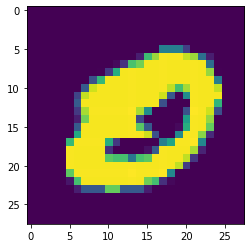

In [16]:
plt.imshow(number_lookup[0][0][0])

We will use a k-NN classifier with k set to n to find the most similar digit

In [17]:
from sklearn.neighbors import KNeighborsClassifier

First we create lists of the encoded vectors and the correct results

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = {
    'train': [],
     'test': []
}
y = {
    'train': [],
     'test': []
}
for batch in trainer.test_loader:
    images = batch[0]
    keys = batch[1]
    for key, image in zip(keys, images):
        features = image.view(EMBEDDING_SIZE).to(device)
        code = model.encode(features)
        X['test'].append(code.detach().numpy())
        y['test'].append(int(key))
for batch in trainer.train_loader:
    images = batch[0]
    keys = batch[1]
    for key, image in zip(keys, images):
        features = image.view(EMBEDDING_SIZE).to(device)
        code = model.encode(features)
        X['train'].append(code.detach().numpy())
        y['train'].append(int(key))

In [84]:
targeter = KNeighborsClassifier(n_neighbors=1)

We fit the kNN-classifier to the train set to check how well it generalises.

In [85]:
targeter.fit(X['train'], y['train'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [87]:
y_pred = {}
y_pred['train'] = [int(targeter.predict(x.reshape(1, -1))[0]) for x in X['train']]
y_pred['test'] = [int(targeter.predict(x.reshape(1, -1))[0]) for x in X['test']]

In [88]:
from sklearn.metrics import classification_report

In [89]:
print(classification_report(y['train'], y_pred['train']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       1.00      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      1.00      1.00      5842
           5       1.00      1.00      1.00      5421
           6       1.00      1.00      1.00      5918
           7       1.00      1.00      1.00      6265
           8       1.00      1.00      1.00      5851
           9       1.00      1.00      1.00      5949

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



In [90]:
print(classification_report(y['test'], y_pred['test']))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.96      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.95      0.95      0.95      1010
           4       0.97      0.95      0.96       982
           5       0.95      0.96      0.95       892
           6       0.97      0.98      0.98       958
           7       0.94      0.96      0.95      1028
           8       0.98      0.92      0.95       974
           9       0.95      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



Scores of 96% seem surprisingly low. We should be able to get higher scores for this.

SOTA is 99.84% accuracy as of November 2020. 96% might be a good first attempt and adjusting the Autoencoder should push us higher.

Time to take a look at the incorrete classifications.

In [111]:
images = {
    'test': []
}
for batch in trainer.test_loader:
    batch_images = batch[0]
    keys = batch[1]
    for key, image in zip(keys, batch_images):
        images['test'].append(image[0])

In [102]:
incorrect_classifications = [i for i in range(len(y['test'])) if y['test'][i] != y_pred['test'][i]]

In [103]:
len(incorrect_classifications)

398

Actual: 2, predicted: 1
Actual: 9, predicted: 4
Actual: 4, predicted: 9
Actual: 3, predicted: 5
Actual: 9, predicted: 8
Actual: 4, predicted: 6
Actual: 8, predicted: 0
Actual: 8, predicted: 3
Actual: 4, predicted: 1
Actual: 2, predicted: 0
Actual: 9, predicted: 7
Actual: 2, predicted: 7
Actual: 3, predicted: 8
Actual: 6, predicted: 4
Actual: 7, predicted: 4
Actual: 4, predicted: 9


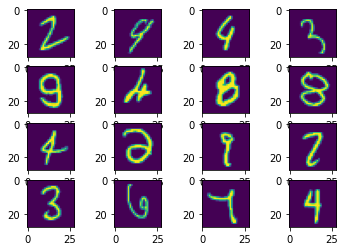

In [119]:
for i, incorrect_classification in enumerate(incorrect_classifications[:16]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images['test'][incorrect_classification])
for incorrect_classification in incorrect_classifications[:16]:
    print(f'Actual: {y["test"][incorrect_classification]}, predicted: {y_pred["test"][incorrect_classification]}')

Once again, those misclassifications seem odd. Most of these should be simple.